# Algorithm Evaluation
(Which algorithm to select for given data)

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

### Step 1: Read the Dataset 

In [2]:
import pandas as pd
df = pd.read_csv('train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Step 2: Perform Basic Data quality checks

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df.duplicated().sum()

0

# Step 3: Seperate X and Y

In [6]:
X = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
Y = df[['Survived']]

In [7]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [8]:
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [9]:
Y.value_counts()

Survived
0           549
1           342
Name: count, dtype: int64

<Axes: xlabel='Survived'>

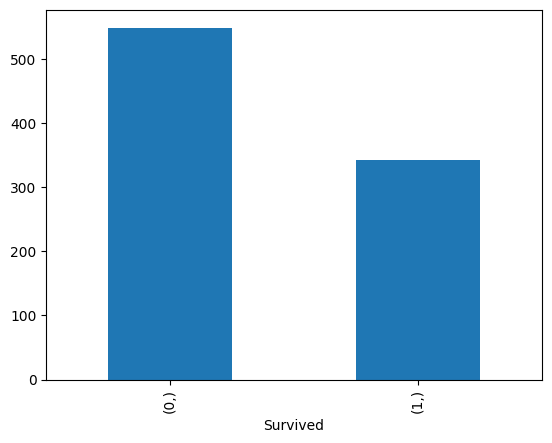

In [10]:
Y.value_counts().plot(kind='bar')

### Step 4: Create a preprocessing Pipeline for X

In [11]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [12]:
cat

['Sex', 'Embarked']

In [13]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [15]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

In [16]:
cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [17]:
pre = ColumnTransformer([('num', num_pipe, con),
                         ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [18]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Embarked'])])

In [19]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0


### Step 5: Apply the train test split

In [20]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=21)

In [21]:
xtrain.shape

(712, 10)

In [22]:
xtest.shape

(179, 10)

### Step 6: Algorithm Evaluation

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [24]:
dct = {'Logistic': LogisticRegression(),
       'Decision Tree':DecisionTreeClassifier(),
       'Random Forest':RandomForestClassifier(),
       'Gradient Boost':GradientBoostingClassifier(),
       'KNN':KNeighborsClassifier(),
       'SVM':SVC()}

In [25]:
dct.items()

dict_items([('Logistic', LogisticRegression()), ('Decision Tree', DecisionTreeClassifier()), ('Random Forest', RandomForestClassifier()), ('Gradient Boost', GradientBoostingClassifier()), ('KNN', KNeighborsClassifier()), ('SVM', SVC())])

In [35]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
train_res = []
test_res = []
train_cv = []
for name, model in dct.items():
    # Fit the model
    model.fit(xtrain, ytrain)
    # Predict results for train and test
    ypred_train = model.predict(xtrain)
    ypred_test = model.predict(xtest)
    # Get F1 macro score for train and test
    f1_train = f1_score(ytrain, ypred_train, average='macro')
    f1_test = f1_score(ytest, ypred_test, average='macro')
    # Cross validate the scores
    scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring='f1_macro')
    f1_cv = scores.mean()
    # Append above results in lists
    train_res.append(f1_train)
    test_res.append(f1_test)
    train_cv.append(f1_cv)
    # Print the results
    print(f'Model Name : {name} \n')
    print(f'Train F1 Macro : {f1_train:.4f}')
    print(f'Test F1 Macro : {f1_test:.4f}')
    print(f'Train F1 Cross Validated : {f1_cv:.4f}')
    print('\n==================================================\n')

Model Name : Logistic 

Train F1 Macro : 0.7876
Test F1 Macro : 0.7931
Train F1 Cross Validated : 0.7820


Model Name : Decision Tree 

Train F1 Macro : 0.9834
Test F1 Macro : 0.7899
Train F1 Cross Validated : 0.7543


Model Name : Random Forest 

Train F1 Macro : 0.9835
Test F1 Macro : 0.8113
Train F1 Cross Validated : 0.7769


Model Name : Gradient Boost 

Train F1 Macro : 0.8943
Test F1 Macro : 0.8285
Train F1 Cross Validated : 0.7899


Model Name : KNN 

Train F1 Macro : 0.8400
Test F1 Macro : 0.8060
Train F1 Cross Validated : 0.7695


Model Name : SVM 

Train F1 Macro : 0.8240
Test F1 Macro : 0.8265
Train F1 Cross Validated : 0.8044




### Create a dataframe to show above results

In [28]:
dct.keys()

dict_keys(['Logistic', 'Decision Tree', 'Random Forest', 'Gradient Boost', 'KNN', 'SVM'])

In [29]:
res = {'Name':list(dct.keys()),
       'Train':train_res,
       'Test':test_res,
       'Train_CV':train_cv}

In [30]:
df_res = pd.DataFrame(res)
df_res

,Name,Train,Test,Train_CV
0,Logistic,0.787602,0.793077,0.781993
1,Decision Tree,0.983432,0.789906,0.753414
2,Random Forest,0.983483,0.810281,0.779211
3,Gradient Boost,0.894330,0.828550,0.789945
4,KNN,0.840032,0.805952,0.769517
5,SVM,0.824030,0.826533,0.804357


In [33]:
df_res.sort_values(by='Train_CV', ascending=False)

,Name,Train,Test,Train_CV
5,SVM,0.824030,0.826533,0.804357
3,Gradient Boost,0.894330,0.828550,0.789945
0,Logistic,0.787602,0.793077,0.781993
2,Random Forest,0.983483,0.810281,0.779211
4,KNN,0.840032,0.805952,0.769517
1,Decision Tree,0.983432,0.789906,0.753414


### From above results Train Cross validation result is highest for SVM hence choosing SVM for final predictions

In [48]:
# Fit SVM model
best_model = SVC(probability=True)
best_model.fit(xtrain, ytrain)

SVC(probability=True)

### Step 7: Evaluating the model

In [49]:
# Accuracy in train
model.score(xtrain, ytrain)

0.8412921348314607

In [50]:
# Accuracy in test
model.score(xtest, ytest)

0.8379888268156425

In [51]:
ypred_train = best_model.predict(xtrain)
ypred_test = best_model.predict(xtest)

In [52]:
ypred_train[0:5]

array([0, 0, 0, 1, 0], dtype=int64)

In [53]:
ytrain.head()

,Survived
793,0
23,1
97,1
9,1
157,0


In [54]:
ypred_test[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [55]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


### Plot the confusion matrix for test

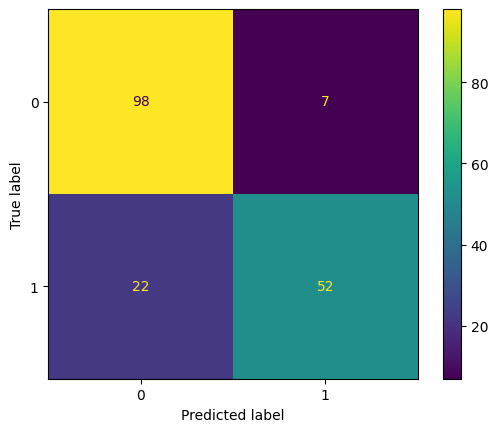

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, xtest, ytest)

In [58]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       105
           1       0.88      0.70      0.78        74

    accuracy                           0.84       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.84      0.84      0.83       179



### Plotting ROC AUC Curve for train and test

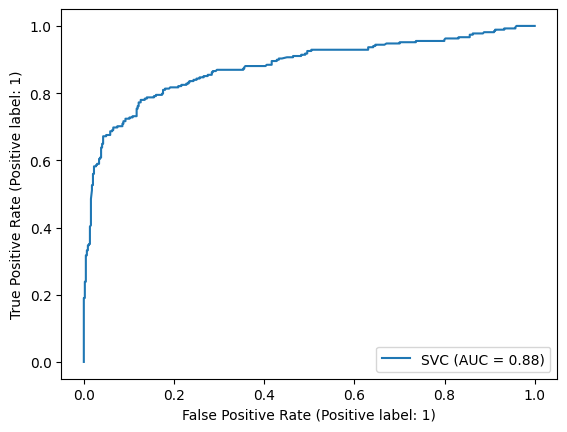

In [59]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(best_model, xtrain, ytrain)

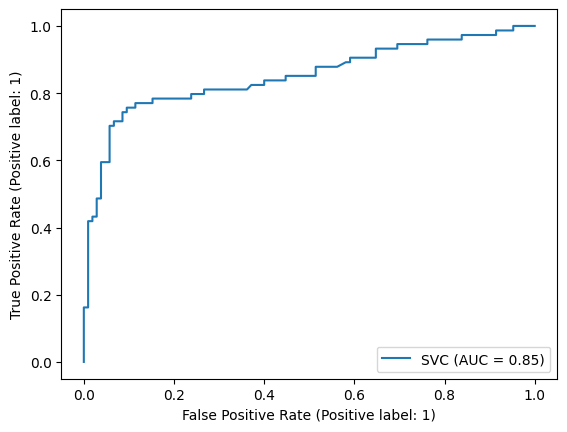

In [60]:
RocCurveDisplay.from_estimator(best_model, xtest, ytest)

In [61]:
roc_scores = cross_val_score(best_model, xtrain, ytrain, cv=5, scoring='roc_auc')

In [62]:
roc_scores

array([0.86371203, 0.83697462, 0.8501166 , 0.83739665, 0.84364478])

In [63]:
roc_scores.mean()

0.8463689345579318

### Step 8: Perform out of sample predictions

In [65]:
xnew = pd.read_csv('test_titanic.csv')
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [66]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Embarked'])])

In [67]:
xnew_pre = pre.transform(xnew)
xnew_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,0.394887,-0.474545,-0.473674,-0.490783,0.0,1.0,0.0,1.0,0.0
1,0.827377,1.355510,0.432793,-0.473674,-0.507479,1.0,0.0,0.0,0.0,1.0
2,-0.369365,2.508257,-0.474545,-0.473674,-0.453367,0.0,1.0,0.0,1.0,0.0
3,0.827377,-0.181487,-0.474545,-0.473674,-0.474005,0.0,1.0,0.0,0.0,1.0
4,0.827377,-0.565736,0.432793,0.767630,-0.401017,1.0,0.0,0.0,0.0,1.0


### Predict results along with probability

In [68]:
preds = best_model.predict(xnew_pre)
probs = best_model.predict_proba(xnew_pre)

In [69]:
preds

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [71]:
prob_sur = probs[:, 1]
prob_sur

array([0.1612468 , 0.41599984, 0.13241067, 0.14850069, 0.4611565 ,
       0.18171679, 0.84920775, 0.17083122, 0.77851748, 0.10491356,
       0.14815315, 0.15900112, 0.88768434, 0.16209696, 0.91011288,
       0.88887487, 0.13850621, 0.17331076, 0.42040868, 0.52962602,
       0.27269984, 0.52133781, 0.90139937, 0.28905842, 0.51595301,
       0.14076302, 0.89432042, 0.16816919, 0.15807254, 0.15886736,
       0.15767671, 0.14078995, 0.34096121, 0.37146299, 0.2185179 ,
       0.18485462, 0.51768642, 0.54306784, 0.14904061, 0.26347215,
       0.1121519 , 0.15882332, 0.15948142, 0.85994695, 0.91119907,
       0.14693849, 0.16171177, 0.15560976, 0.81208567, 0.50938999,
       0.18369746, 0.13588456, 0.74036415, 0.85208524, 0.13497813,
       0.13165437, 0.1557342 , 0.14658226, 0.11932902, 0.823825  ,
       0.16249947, 0.14853503, 0.15821104, 0.85805501, 0.51042873,
       0.87190177, 0.85598492, 0.15927026, 0.156918  , 0.25447536,
       0.85786321, 0.15025287, 0.51484191, 0.1590624 , 0.85117

### Save above results in dataframe and csv

In [72]:
df_final = xnew[['PassengerId']]
df_final

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [73]:
df_final['Survived_pred'] = preds
df_final['Probability'] = prob_sur

In [74]:
df_final

,PassengerId,Survived_pred,Probability
0,892,0,0.161247
1,893,0,0.416000
2,894,0,0.132411
3,895,0,0.148501
4,896,0,0.461157
...,...,...,...
413,1305,0,0.148358
414,1306,1,0.878018
415,1307,0,0.157791
416,1308,0,0.148358


In [75]:
df_final['Survived_pred'].value_counts()

Survived_pred
0    275
1    143
Name: count, dtype: int64

<Axes: xlabel='Survived_pred'>

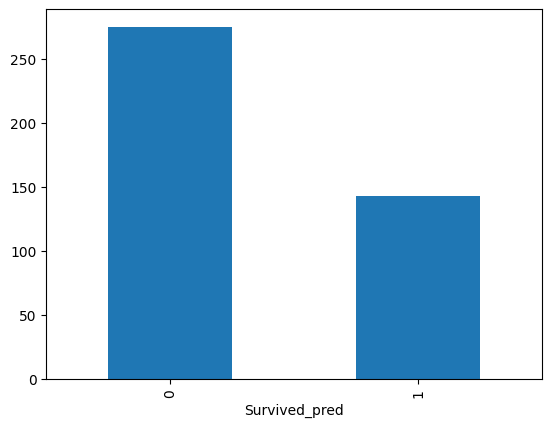

In [76]:
df_final['Survived_pred'].value_counts().plot(kind='bar')

# Save above results to csv

In [78]:
df_final.to_csv('Results.csv', index=False)